### Build a basic chatbot with langgraph (graph api)

In [1]:
from typing import Annotated #Used to add meta data which will imporove readablity and maintainablity 

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages #Reducers which will add messages into a variable we define with out replacing already existing messages

In [2]:
class State(TypedDict):
    """Messages have the type 'list'. The 'add message' function in the annotation defines how this state should be 
    updated (in this case, it appends messages to the list, rather than overwriting them) """
    messages:Annotated[list,add_messages]



In [7]:
import os
from dotenv import load_dotenv #Used to store api keys in the .env and file and used to import those in 
load_dotenv()

True

In [8]:

from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama3-8b-8192")


In [11]:
## Node functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [12]:
graph_builder=StateGraph(State)

##Adding node to the graph
graph_builder.add_node("llmchatbot",chatbot)
##Adding edge to the graph
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

##Compile the graph
graph=graph_builder.compile()

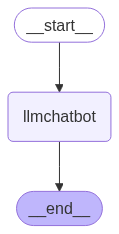

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [14]:
graph.invoke({"messages":"Hi"})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='0bda8452-1ba4-48be-8936-ffb44bc7ebf9'),
  AIMessage(content="Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.017566296, 'prompt_time': 0.001670837, 'queue_time': 0.268226748, 'total_time': 0.019237133}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--722b000b-3a06-43ec-88c8-c3f8e6065927-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})]}

In [15]:
response=graph.invoke({'messages':"Which is the best ipl team?"})
response

{'messages': [HumanMessage(content='Which is the best ipl team?', additional_kwargs={}, response_metadata={}, id='ed692683-b928-4b97-96d8-92cbb434d6ae'),
  AIMessage(content='A question that sparks debate and passion among cricket fans!\n\nThe Indian Premier League (IPL) has been a thrilling competition since its inception in 2008. While opinions may vary, here are some facts and statistics to help you decide:\n\n**Most successful teams:**\n\n1. Mumbai Indians (MI) - 5 titles (2013, 2015, 2017, 2019, 2020)\n2. Chennai Super Kings (CSK) - 4 titles (2010, 2011, 2018, 2021)\n3. Kolkata Knight Riders (KKR) - 2 titles (2012, 2014)\n\n**Recent form:**\n\n1. Mumbai Indians - Consistent performers, with a strong squad and a good balance of youth and experience.\n2. Delhi Capitals (DC) - Showed impressive growth in the last two seasons, reaching the playoffs and finishing as runners-up in 2020.\n3. Kolkata Knight Riders - Had a strong run in the 2020 season, but struggled in the 2021 season.\n\

In [16]:
for event in graph.stream({"messages":"Hi How are you?"}): #event contains messages of every node in the graph
    for value in event.values():
        print(value["messages"][0].content)

Hi! I'm just an AI, so I don't have feelings like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have! How about you? How's your day going so far?


In [34]:
response['messages'][-1].content


'A question that sparks debate and passion among cricket fans!\n\nThe Indian Premier League (IPL) is a highly competitive tournament, and each team has its own strengths and weaknesses. It\'s difficult to pinpoint a single "best" team, as the outcome of the season can depend on various factors, such as team composition, player performances, and strategic decisions.\n\nThat being said, here are some of the most successful IPL teams, based on their performance over the years:\n\n1. **Mumbai Indians**: With five IPL titles (2013, 2015, 2017, 2019, and 2020), Mumbai Indians are one of the most successful teams in the tournament. They have a strong squad, excellent team management, and a winning culture.\n2. **Chennai Super Kings**: The Yellow Army has four IPL titles (2010, 2011, 2018, and 2021) and has been a consistent top-performing team. They have a strong core of experienced players and a good balance of youth and experience.\n3. **Kolkata Knight Riders**: The Knight Riders have two I

### Chatbot with tools

In [21]:
from langchain_tavily import TavilySearch #A tool that is used to take data from external source internet

tool=TavilySearch(max_results=2) # max results to fetch from the internet
tool.invoke("What is langgraph?")

{'query': 'What is langgraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [20]:
# Custom multiply functions 
def multiply(a:int,b:int)->int:
    """
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output
    """
    return a*b

In [22]:
tools=[tool,multiply]
llm_with_tools=llm.bind_tools(tools)


In [23]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001965B5C0400>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001965B5C0040>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

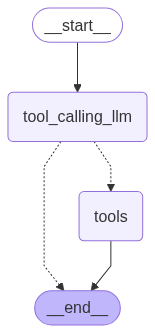

In [15]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node defenition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## graph builder
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##Add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph=builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [30]:
response=graph.invoke({"messages":"What is latest ai news"})
response['messages'][-1].content


'{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/news/computers_math/artificial_intelligence/", "title": "Artificial Intelligence News - ScienceDaily", "content": "ScienceDaily\\n\\n# Artificial Intelligence News\\n\\n## Top Headlines\\n\\n## Latest Headlines\\n\\n## Earlier Headlines\\n\\n### Tuesday, May 27, 2025\\n\\n### Thursday, May 22, 2025\\n\\n### Wednesday, May 21, 2025\\n\\n### Monday, May 19, 2025\\n\\n### Thursday, May 15, 2025\\n\\n### Wednesday, May 14, 2025\\n\\n### Tuesday, May 13, 2025\\n\\n### Monday, May 12, 2025\\n\\n### Thursday, May 8, 2025\\n\\n### Wednesday, May 7, 2025\\n\\n### Tuesday, May 6, 2025\\n\\n### Monday, May 5, 2025\\n\\n### Thursday, May 1, 2025\\n\\n### Wednesday, April 30, 2025 [...] ### Monday, April 28, 2025\\n\\n### Friday, April 25, 2025\\n\\n### Thursday, April 24, 2025\\n\\n### Wednesday, April 23, 2025\\n\\n### Tuesday, April 22, 2025\\n\\n### Monday, A

In [32]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is latest ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (nbmhzb97y)
 Call ID: nbmhzb97y
  Args:
    query: latest ai news
    search_depth: advanced
    time_range: day
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "latest ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.sciencedaily.com/news/computers_math/artificial_intelligence/", "title": "Artificial Intelligence News - ScienceDaily", "content": "ScienceDaily\n\n# Artificial Intelligence News\n\n## Top Headlines\n\n## Latest Headlines\n\n## Earlier Headlines\n\n### Tuesday, May 27, 2025\n\n### Thursday, May 22, 2025\n\n### Wednesday, May 21, 2025\n\n### Monday, May 19, 2025\n\n### Thursday, May 15, 2025\n\n### Wednesday, May 14, 2025\n\n### 

In [40]:
response=graph.invoke({"messages":"Get me the recent AI news and then multiply 5 and 2"})
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

Get me the recent AI news and then multiply 5 and 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fzsgaq45m)
 Call ID: fzsgaq45m
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
  multiply (naxzv35yj)
 Call ID: naxzv35yj
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techcrunch.com/category/artificial-intelligence/", "title": "AI News & Artificial Intelligence | TechCrunch", "content": "The Meta Platforms Inc. pavilion ahead of the World Economic Forum (WEF) in Davos, Switzerland, on Jan. 19, 2025.\n\n### Meta to spend up to $72B on AI infrastructure in 2025 as compute arms race escalates\n\n### Zuckerberg signals Me

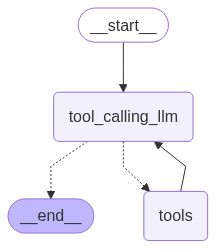

In [8]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##Node defenition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## graph builder
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##Add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [42]:
response=graph.invoke({"messages":"Get me the recent AI news and then multiply 5 and 2"})
for m in response["messages"]:
    m.pretty_print()


================================ Human Message =================================

Get me the recent AI news and then multiply 5 and 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7va5qeyvp)
 Call ID: 7va5qeyvp
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/nasas-spacex-crew-11-makes-a-stellar-splash-at-the-iss", "title": "NASA's SpaceX Crew-11 Makes a Stellar Splash at the ISS! - OpenTools", "score": 0.8409005, "published_date": "Sun, 03 Aug 2025 09:12:52 GMT", "content": "Latest AI News: Daily Updated Artificial Intelligence Insights (August 3, 2025)\n\n===============\n\nOpenToolsImage 1: logo\n\nOpen main menu\n\nNewsletterNewsSubmit A ToolAdvertise\n\nCateg

In [44]:
for m in state["messages"]:
    print(m)

NameError: name 'state' is not defined

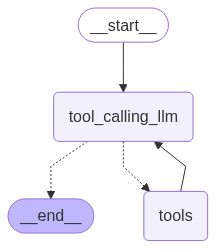

In [9]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
##Node defenition

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## graph builder
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##Add edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile(checkpointer=memory)
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [10]:
config={"configurable" : {"thread_id":"1"}}
response=graph.invoke({"messages":"Hi my name is Akshay"},config=config)

In [11]:
response

{'messages': [HumanMessage(content='Hi my name is Akshay', additional_kwargs={}, response_metadata={}, id='106d2163-74e7-4e85-8c10-654774bad994'),
  AIMessage(content='Nice to meet you, Akshay! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 2902, 'total_tokens': 2919, 'completion_time': 0.014801709, 'prompt_time': 0.402125223, 'queue_time': 0.267906458, 'total_time': 0.416926932}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--cb66a8ac-57b6-4362-9f50-a4fc491425b2-0', usage_metadata={'input_tokens': 2902, 'output_tokens': 17, 'total_tokens': 2919})]}

In [12]:
response=graph.invoke({"messages":"Do you know my name"},config=config)

In [13]:
response

{'messages': [HumanMessage(content='Hi my name is Akshay', additional_kwargs={}, response_metadata={}, id='106d2163-74e7-4e85-8c10-654774bad994'),
  AIMessage(content='Nice to meet you, Akshay! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 2902, 'total_tokens': 2919, 'completion_time': 0.014801709, 'prompt_time': 0.402125223, 'queue_time': 0.267906458, 'total_time': 0.416926932}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_0fb809dba3', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--cb66a8ac-57b6-4362-9f50-a4fc491425b2-0', usage_metadata={'input_tokens': 2902, 'output_tokens': 17, 'total_tokens': 2919}),
  HumanMessage(content='Do you know my name', additional_kwargs={}, response_metadata={}, id='bd61b7d6-9f18-4005-b078-5d4416e3461c'),
  AIMessage(content='I was just told that your name is Akshay.', additional_kwargs={}, response_metadata={'token_usage': {'

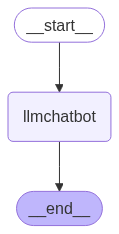

In [11]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder=StateGraph(State)

##Adding node to the graph
graph_builder.add_node("llmchatbot",chatbot)
##Adding edge to the graph
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

##Compile the graph
graph=graph_builder.compile(checkpointer=memory)

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))



In [14]:
config={"configurable" : {"thread_id":"2"}}
for chunk in graph.stream({"messages":"Hi, my name is Akshay and I like cricket"},config,stream_mode="updates"):
    print(chunk)

{'llmchatbot': {'messages': [AIMessage(content="Nice to meet you, Akshay! Cricket is a great sport, isn't it? Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 22, 'total_tokens': 51, 'completion_time': 0.086328937, 'prompt_time': 0.013777467, 'queue_time': 0.264655214, 'total_time': 0.100106404}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d066c216-1dcb-44ad-97a3-d0c61ffdfdbb-0', usage_metadata={'input_tokens': 22, 'output_tokens': 29, 'total_tokens': 51})]}}


In [16]:
config={"configurable" : {"thread_id":"2"}}
for chunk in graph.stream({"messages":"I also like badminton"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, my name is Akshay and I like cricket', additional_kwargs={}, response_metadata={}, id='ad7aa783-afcb-4dca-bfb4-f8bcecba1d55'), AIMessage(content="Nice to meet you, Akshay! Cricket is a great sport, isn't it? Do you have a favorite team or player?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 22, 'total_tokens': 51, 'completion_time': 0.086328937, 'prompt_time': 0.013777467, 'queue_time': 0.264655214, 'total_time': 0.100106404}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d066c216-1dcb-44ad-97a3-d0c61ffdfdbb-0', usage_metadata={'input_tokens': 22, 'output_tokens': 29, 'total_tokens': 51}), HumanMessage(content='Hi, my name is Akshay and I like cricket', additional_kwargs={}, response_metadata={}, id='9df283df-cc0b-4af1-a63c-a743b825f4f2'), AIMessage(content="Nice to meet you, Akshay! Cr